In [244]:
import torch
import torch.nn as nn
import torch.utils.data as data

import scanpy as sc
import pandas as pd
import numpy as np

In [181]:
adata = sc.read('mouse_retina_hvg.h5ad')

In [185]:
select_genes = adata.varm['I'].sum(1)>0

In [186]:
adata._inplace_subset_var(select_genes)

In [225]:
EPOCH = 20
BATCH_SIZE = 65
LR = 0.0005
ALPHA = 0.5

In [226]:
class AutoEncoder(nn.Module):
    def __init__(self, n_vars, n_terms):
        super(AutoEncoder, self).__init__()
        
        self.first_layer = nn.Linear(n_vars, n_terms)

        self.encoder = nn.Sequential(
            self.first_layer,
            nn.Tanh(),
            nn.Linear(n_terms, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, n_terms),
            nn.Tanh(),
            nn.Linear(n_terms, n_vars),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [227]:
autoencoder = AutoEncoder(adata.n_vars, len(adata.uns['terms']))

In [228]:
def get_loss_func(I, alpha):
    l2_loss = nn.MSELoss()
    I = torch.tensor(1-I.T, dtype=torch.float32, requires_grad=False)
    def regularized_loss(X, Y, W):
        return l2_loss(X, Y) + alpha*torch.norm(W*I, 1)
    return regularized_loss

In [229]:
loss_func = get_loss_func(adata.varm['I'], ALPHA)

In [230]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)

In [231]:
for epoch in range(EPOCH):
    for step in range(int(adata.n_obs/BATCH_SIZE)):
        X = torch.from_numpy(adata.chunk_X(BATCH_SIZE))
        encoded, decoded = autoencoder(X)
        loss = loss_func(decoded, X, autoencoder.first_layer.weight)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0: print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

Epoch:  0 | train loss: 1039.6031
Epoch:  0 | train loss: 5.3842
Epoch:  0 | train loss: 4.0985
Epoch:  0 | train loss: 4.0776
Epoch:  0 | train loss: 4.1045
Epoch:  0 | train loss: 4.0921
Epoch:  0 | train loss: 4.0640
Epoch:  1 | train loss: 4.0758
Epoch:  1 | train loss: 4.0259
Epoch:  1 | train loss: 4.0660
Epoch:  1 | train loss: 4.0597
Epoch:  1 | train loss: 4.0373
Epoch:  1 | train loss: 4.0487
Epoch:  1 | train loss: 4.0685
Epoch:  2 | train loss: 4.0216
Epoch:  2 | train loss: 4.0890
Epoch:  2 | train loss: 4.0499
Epoch:  2 | train loss: 4.0413
Epoch:  2 | train loss: 4.0403
Epoch:  2 | train loss: 4.0810
Epoch:  2 | train loss: 4.0123
Epoch:  3 | train loss: 4.0349
Epoch:  3 | train loss: 4.0518
Epoch:  3 | train loss: 3.9945
Epoch:  3 | train loss: 4.0455
Epoch:  3 | train loss: 4.0285
Epoch:  3 | train loss: 4.0442
Epoch:  3 | train loss: 3.9903
Epoch:  4 | train loss: 3.9859
Epoch:  4 | train loss: 4.0322
Epoch:  4 | train loss: 4.0300
Epoch:  4 | train loss: 4.0103
Epoch

In [239]:
adata.obsm['X_encoded'] = autoencoder.encoder(torch.from_numpy(adata.X)).detach().numpy()

In [241]:
large_clusters = []
for cl in adata.obs['cluster']:
    if cl == 1: large_clusters.append('Horizontal cells')
    elif cl == 2: large_clusters.append('Retinal ganglion cells')
    elif cl >= 3 and cl <= 23: large_clusters.append('Amacrine cells')
    elif cl == 24: large_clusters.append('Rodes')
    elif cl == 25: large_clusters.append('Cones')
    elif cl >= 26 and cl <= 33: large_clusters.append('Bipolar cells')
    elif cl == 34: large_clusters.append('Muller glia')
    elif cl == 35: large_clusters.append('Astocytes')
    elif cl == 36: large_clusters.append('Fibroblasts')
    elif cl == 37: large_clusters.append('Vascular endothelium')
    elif cl == 38: large_clusters.append('Perioytes')
    elif cl == 39: large_clusters.append('Microglia')

In [245]:
adata.obs['cell_type'] = pd.Categorical(values=large_clusters)

In [260]:
from scanpy.plotting._tools import plot_scatter

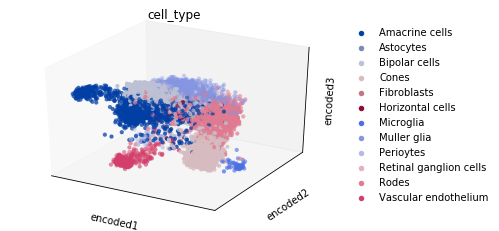

In [267]:
fig = plot_scatter(adata, basis='encoded', projection='3d', color='cell_type', return_fig=True, size=70)

In [268]:
fig.set_size_inches(15, 15)

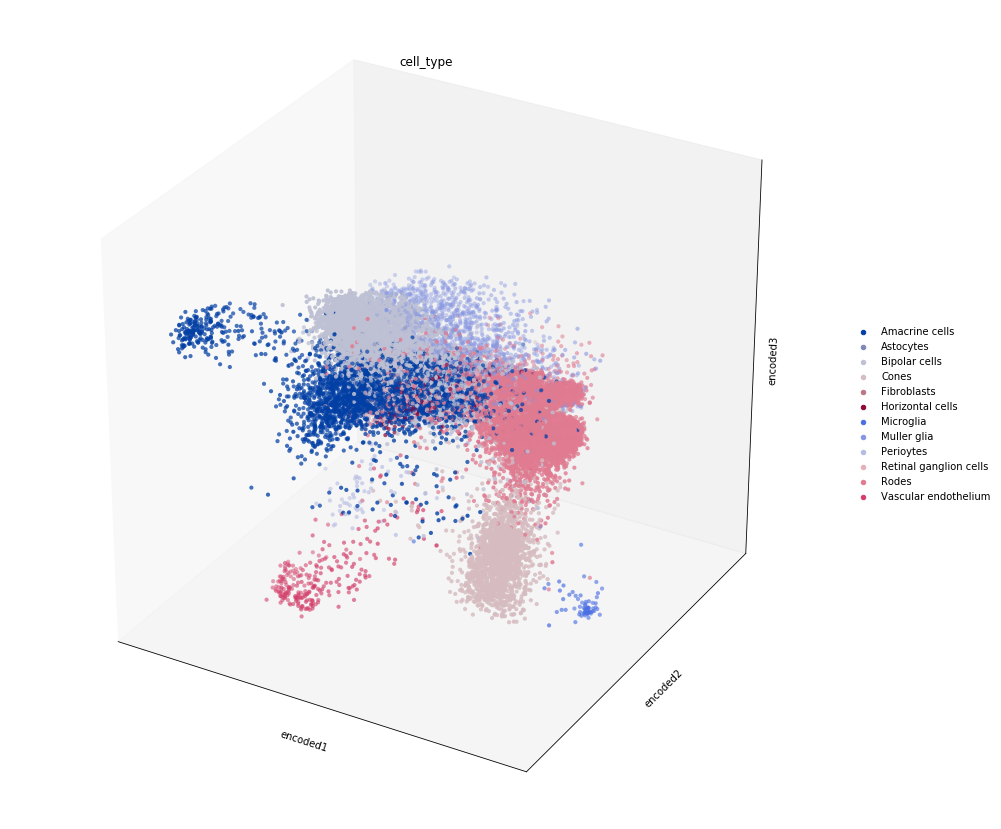

In [269]:
fig